In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

sentiment = pd.read_csv("fear_greed_index.csv")

sentiment['date'] = pd.to_datetime(sentiment['timestamp'], unit='s')
sentiment['date'] = sentiment['date'].dt.date

def simplify_sentiment(x):
    if "Fear" in x:
        return "Fear"
    elif "Greed" in x:
        return "Greed"
    else:
        return "Neutral"

sentiment['sentiment_group'] = sentiment['classification'].apply(simplify_sentiment)

print("Shape:", sentiment.shape)
print("\nMissing values:\n", sentiment.isnull().sum())
print("\nDuplicates:", sentiment.duplicated().sum())
print("\nDistribution:\n", sentiment['sentiment_group'].value_counts())

Shape: (2644, 5)

Missing values:
 timestamp          0
value              0
classification     0
date               0
sentiment_group    0
dtype: int64

Duplicates: 0

Distribution:
 sentiment_group
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


In [6]:
import pandas as pd
trades = pd.read_csv("historical_data.csv")
print("Before conversion:")
print(trades['Timestamp IST'].head())
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)
trades['date'] = trades['Timestamp IST'].dt.date
trades['time'] = trades['Timestamp IST'].dt.time
print("\nAfter conversion:")
print(trades.head())
print("\nData Types:")
print(trades.dtypes)

Before conversion:
0    02-12-2024 22:50
1    02-12-2024 22:50
2    02-12-2024 22:50
3    02-12-2024 22:50
4    02-12-2024 22:50
Name: Timestamp IST, dtype: object

After conversion:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564   

In [7]:
merged = trades.merge(
    sentiment[['date','sentiment_group','value']],
    on='date',
    how='left'
)

print(merged.shape)

(211224, 20)


In [8]:
daily_pnl = merged.groupby(['Account','date'])['Closed PnL'].sum().reset_index()

In [9]:
merged['win'] = merged['Closed PnL'] > 0

win_rate = merged.groupby('Account')['win'].mean().reset_index()

In [10]:
avg_size = merged.groupby('Account')['Size USD'].mean().reset_index()

In [11]:
trades_per_day = merged.groupby('date')['Account'].count().reset_index()
trades_per_day.columns = ['date','trade_count']

In [12]:
long_short = merged.groupby(['sentiment_group','Side']).size().unstack()
print(long_short)

Side               BUY   SELL
sentiment_group              
Fear             41205  42032
Greed            42516  47779
Neutral          18969  18717


In [13]:
long_short = merged.groupby(['sentiment_group','Side']).size().unstack()
print(long_short)

Side               BUY   SELL
sentiment_group              
Fear             41205  42032
Greed            42516  47779
Neutral          18969  18717


In [14]:
print(merged.groupby('sentiment_group')['Closed PnL'].mean())
print(merged.groupby('sentiment_group')['win'].mean())


sentiment_group
Fear       49.212077
Greed      53.882281
Neutral    34.307718
Name: Closed PnL, dtype: float64
sentiment_group
Fear       0.407871
Greed      0.420311
Neutral    0.396991
Name: win, dtype: float64


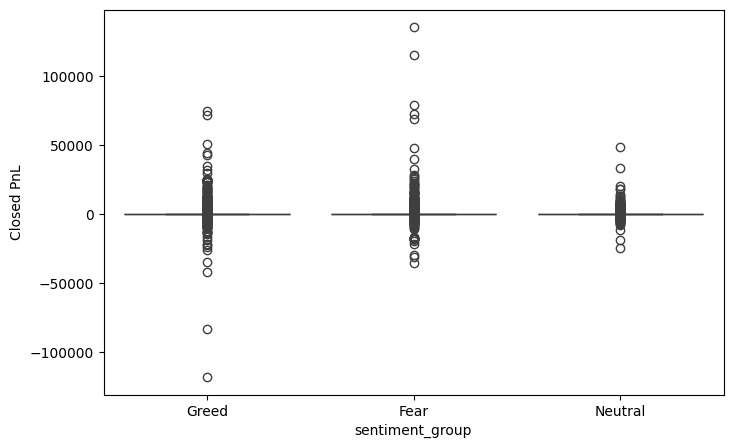

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment_group', y='Closed PnL', data=merged)
plt.show()

In [16]:
trade_counts = merged.groupby('Account').size()
threshold = trade_counts.quantile(0.7)

merged['frequency_segment'] = merged['Account'].apply(
    lambda x: 'Frequent' if trade_counts[x] > threshold else 'Infrequent'
)

In [17]:
pnl_std = merged.groupby('Account')['Closed PnL'].std()
median_std = pnl_std.median()

merged['consistency_segment'] = merged['Account'].apply(
    lambda x: 'Consistent' if pnl_std[x] < median_std else 'Inconsistent'
)

In [18]:
print(
    merged.groupby(['frequency_segment','sentiment_group'])['Closed PnL'].mean()
)

frequency_segment  sentiment_group
Frequent           Fear               26.730589
                   Greed              47.437892
                   Neutral            30.723414
Infrequent         Fear               96.380780
                   Greed              78.596990
                   Neutral            48.925557
Name: Closed PnL, dtype: float64


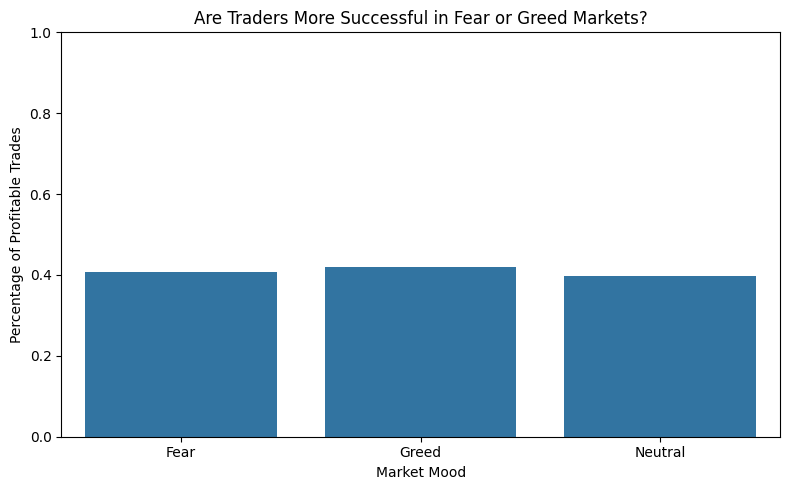

In [19]:
win_rate = merged.groupby('sentiment_group')['win'].mean().reset_index()

plt.figure(figsize=(8,5))

sns.barplot(data=win_rate, x='sentiment_group', y='win')

plt.xlabel("Market Mood")
plt.ylabel("Percentage of Profitable Trades")
plt.title("Are Traders More Successful in Fear or Greed Markets?")

plt.ylim(0,1)

plt.tight_layout()
plt.show()

In [20]:
win_rate['win'] = win_rate['win'] * 100

In [21]:
merged['sentiment_label'] = merged['sentiment_group'].map({
    'Fear': 'Fearful Market',
    'Greed': 'Greedy Market',
    'Neutral': 'Neutral Market'
})

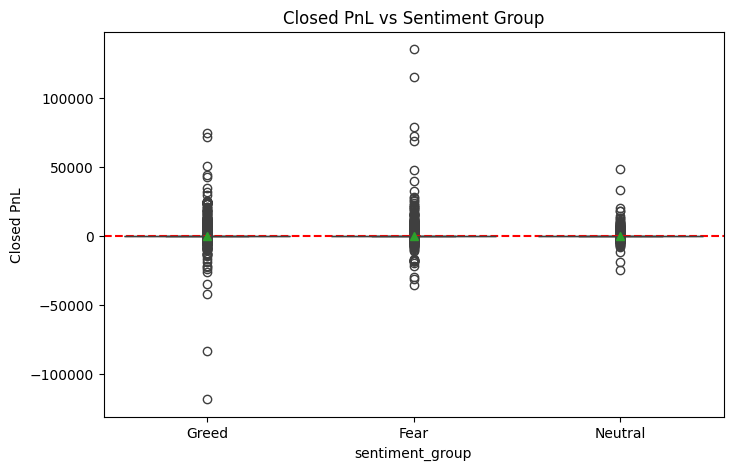

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

sns.boxplot(
    data=merged,
    x='sentiment_group',
    y='Closed PnL',
    showmeans=True
)

plt.axhline(0, color='red', linestyle='--')

plt.title("Closed PnL vs Sentiment Group")
plt.show()

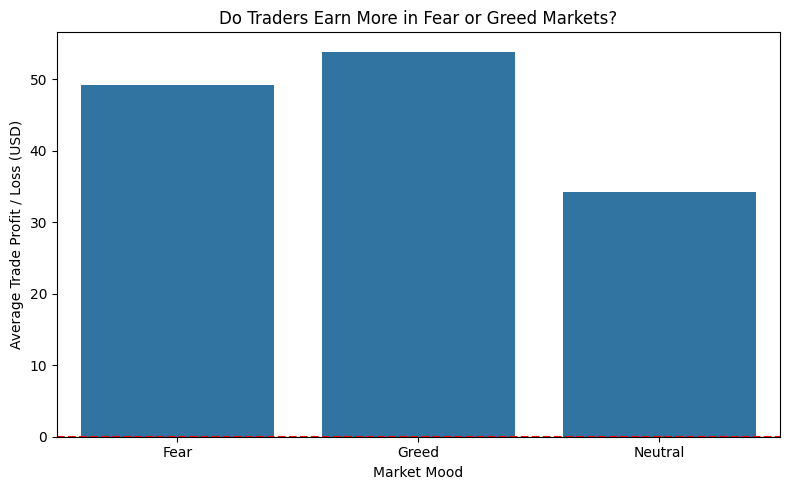

In [27]:
avg_pnl = merged.groupby('sentiment_group')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(8,5))

sns.barplot(data=avg_pnl, x='sentiment_group', y='Closed PnL')

plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Market Mood")
plt.ylabel("Average Trade Profit / Loss (USD)")
plt.title("Do Traders Earn More in Fear or Greed Markets?")

plt.tight_layout()
plt.show()